<a href="https://colab.research.google.com/github/ekourkchi/incNET-data/blob/master/Resnet50_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import os
import subprocess
from math import *
import numpy as np
from datetime import *
from pylab import *
import matplotlib as mpl
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.pyplot as plt
from astropy.table import Table, Column 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import scipy.misc as scimisc
import random
from sklearn.model_selection import train_test_split

# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
data = np.load('/content/drive/My Drive/data_64x64.npz')
images_ = data['images']
labels_ = data['labels'] 
data.close() 

In [3]:
ix, = np.where(labels_[1]>50)

images_c = images_[ix]
labels_c = labels_[1][ix]
pgcIDs_c = labels_[0][ix]

images_train, images_test, labels_train, labels_test, pgcIDs_train,  pgcIDs_test = train_test_split(images_c, labels_c, pgcIDs_c, test_size=0.40)

notUnique = np.isin(pgcIDs_test, pgcIDs_train)
Unique = np.logical_not(notUnique)

images_train = np.concatenate((images_train, images_test[notUnique]))
labels_train  = np.concatenate((labels_train, labels_test[notUnique]))
pgcIDs_train = np.concatenate((pgcIDs_train, pgcIDs_test[notUnique]))

images_test = images_test[Unique]
labels_test = labels_test[Unique]
pgcIDs_test = pgcIDs_test[Unique]


In [4]:
print(images_train.shape)
print(images_test.shape)
print(labels_train.shape)
print(labels_test.shape)
print(pgcIDs_train.shape)
print(pgcIDs_test.shape)

(41916, 64, 64, 3)
(1108, 64, 64, 3)
(41916,)
(1108,)
(41916,)
(1108,)


In [5]:
labels_train  = labels_train - 51
labels_test   = labels_test - 51
images_test   = images_test / 255.
images_train  = images_train / 255.

In [23]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
import keras

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(64, 64,3))

resnet.trainable = False

# for layer in resnet.layers[:-4]:
#     layer.trainable = False

In [24]:
import pandas as pd
layers = [(layer, layer.name, layer.trainable) for layer in resnet.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']).tail(18)

,Layer Type,Layer Name,Layer Trainable
157,<tensorflow.python.keras.layers.core.Activatio...,conv5_block2_1_relu,False
158,<tensorflow.python.keras.layers.convolutional....,conv5_block2_2_conv,False
159,<tensorflow.python.keras.layers.normalization_...,conv5_block2_2_bn,False
160,<tensorflow.python.keras.layers.core.Activatio...,conv5_block2_2_relu,False
161,<tensorflow.python.keras.layers.convolutional....,conv5_block2_3_conv,False
162,<tensorflow.python.keras.layers.normalization_...,conv5_block2_3_bn,False
163,<tensorflow.python.keras.layers.merge.Add obje...,conv5_block2_add,False
164,<tensorflow.python.keras.layers.core.Activatio...,conv5_block2_out,False
165,<tensorflow.python.keras.layers.convolutional....,conv5_block3_1_conv,False
166,<tensorflow.python.keras.layers.normalization_...,conv5_block3_1_bn,False


In [25]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()

model.add(resnet)
# for layer in resnet.layers[:-1]: # just exclude last layer from copying
#   model.add(layer)

model.add(Flatten())
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(40, activation='softmax'))

# model.summary()

In [26]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
n_epochs = 30
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dense_5 (Dense)              (None, 40)                5160      
Total params: 24,641,576
Trainable params: 1,053,864
Non-trainable params: 23,587,712
_________________________________________________________________


In [27]:
model_history = model.fit(images_train, labels_train, 
                                  epochs=n_epochs, batch_size=512, verbose=2, 
                                  validation_data=(images_test, labels_test),
                                  shuffle=False)

Epoch 1/30
82/82 - 8s - loss: 3.6138 - accuracy: 0.0462 - val_loss: 3.5498 - val_accuracy: 0.0397
Epoch 2/30
82/82 - 7s - loss: 3.5268 - accuracy: 0.0514 - val_loss: 3.4444 - val_accuracy: 0.0532
Epoch 3/30
82/82 - 7s - loss: 3.3886 - accuracy: 0.0731 - val_loss: 3.3042 - val_accuracy: 0.1146
Epoch 4/30
82/82 - 7s - loss: 3.2515 - accuracy: 0.0940 - val_loss: 3.2072 - val_accuracy: 0.1182
Epoch 5/30
82/82 - 7s - loss: 3.1637 - accuracy: 0.1013 - val_loss: 3.1483 - val_accuracy: 0.1209
Epoch 6/30
82/82 - 7s - loss: 3.1096 - accuracy: 0.1073 - val_loss: 3.1078 - val_accuracy: 0.1255
Epoch 7/30
82/82 - 7s - loss: 3.0722 - accuracy: 0.1107 - val_loss: 3.0766 - val_accuracy: 0.1264
Epoch 8/30
82/82 - 7s - loss: 3.0439 - accuracy: 0.1117 - val_loss: 3.0519 - val_accuracy: 0.1255
Epoch 9/30
82/82 - 7s - loss: 3.0211 - accuracy: 0.1145 - val_loss: 3.0312 - val_accuracy: 0.1173
Epoch 10/30
82/82 - 7s - loss: 3.0019 - accuracy: 0.1161 - val_loss: 3.0142 - val_accuracy: 0.1209
Epoch 11/30
82/82 -

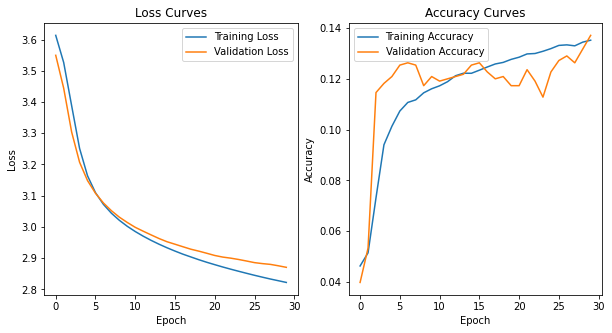

In [28]:
def plot_model_history(history):
    '''Plot the training and validation history for a TensorFlow network'''

    # Extract loss and accuracy
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
    ax[0].plot(np.arange(n_epochs), loss, label='Training Loss')
    ax[0].plot(np.arange(n_epochs), val_loss, label='Validation Loss')
    ax[0].set_title('Loss Curves')
    ax[0].legend()
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(np.arange(n_epochs), acc, label='Training Accuracy')
    ax[1].plot(np.arange(n_epochs), val_acc, label='Validation Accuracy')
    ax[1].set_title('Accuracy Curves')
    ax[1].legend()
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    
# plot the training history
# print vgg_model.history.history['loss']

plot_model_history(model_history)
  

In [29]:
inc_p = model.predict(images_test)
inc_m = labels_test +51


N = images_test.shape[0]

inc_p = np.argmax(inc_p, axis=1) + 51

6.64310668482697
7.429925828169766


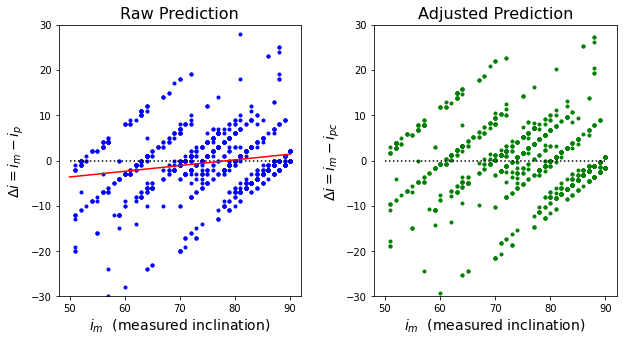

In [30]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5)) 

d = inc_m-inc_p

m, b = np.polyfit(inc_m, d, 1)
x = np.linspace(50,90,20)
y  = m*x+b

ax[0].plot(inc_m, d, 'b.')
ax[0].plot([50,90],[0,0], 'k:')
ax[0].plot(x, y, 'r-')
ax[0].set_xlim(48,92)
ax[0].set_ylim(-30,30)
ax[0].set_title('Raw Prediction', fontsize=16)
ax[0].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[0].set_ylabel(r'$\Delta i = i_m-i_p$', fontsize=14)

print(np.sqrt(np.mean((d)**2)))


d_ = inc_m-(inc_p+b)/(1.-m)
ax[1].plot(inc_m, d_, 'g.')
ax[1].plot([50,90],[0,0], 'k:')
ax[1].set_xlim(48,92)
ax[1].set_ylim(-30,30)

print(np.sqrt(np.mean((d_)**2)))
ax[1].set_title('Adjusted Prediction', fontsize=16)
ax[1].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[1].set_ylabel(r'$\Delta i = i_m-i_{pc}$', fontsize=14)

plt.subplots_adjust( wspace=0.3)